In [265]:
%load_ext autoreload
%autoreload 2
import random
from Environment import Environment
from CompanyAgent import CompanyAgent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [266]:
def generate_agents(
        count,
        expected_emission, 
        initial_allowance, 
        sell_price, 
        buy_price, 
        activate_abatement=True, 
        emission_rate_noise=0.01, 
        expected_emission_noise=0.1):
    
    agents = []
    for i in range(count):
        agents.append(CompanyAgent(
            expected_emission, 
            initial_allowance, 
            sell_price, 
            buy_price, 
            activate_abatement=activate_abatement, 
            emission_rate_noise=emission_rate_noise,
            expected_emission_noise=expected_emission_noise))
    return agents


In [267]:
random.seed(41)
np.random.seed(41)
# create two agents
# define 100 agents with random expected emission, initial allowance, sell price and buy pric

states = ['idle', 'simple_trade', 'simple_trade_deficit', 'noise_trade_deficit']

state = "noise_trade_deficit"

agents = []
if state == "idle":
    #base state, everyone has what he needs
    idle_agents = generate_agents(200, 10000, 10000, 0, 100, activate_abatement=False, emission_rate_noise=0, expected_emission_noise=0)
    agents += idle_agents

if state == "simple_trade":
    #trading but market is saturated behavior
    selling_agents = generate_agents(100, 10000, 10100, 0, 100, activate_abatement=False, emission_rate_noise=0, expected_emission_noise=0)
    buying_agents = generate_agents(100, 10000, 9900, 0, 100, activate_abatement=False, emission_rate_noise=0, expected_emission_noise=0)
    agents += selling_agents
    agents += buying_agents

if state == "simple_trade_deficit":
    #trading but market has a dificit
    selling_agents = generate_agents(100, 10000, 10100, 0, 100, activate_abatement=False, emission_rate_noise=0, expected_emission_noise=0)
    buying_agents = generate_agents(100, 10000, 9800, 0, 100, activate_abatement=False, emission_rate_noise=0, expected_emission_noise=0)
    agents += selling_agents
    agents += buying_agents


if state == "noise_trade_deficit":
    #trading but market has a dificit
    selling_agents = generate_agents(100, 1000, 1100, 0, 100, activate_abatement=False, emission_rate_noise=0.1, expected_emission_noise=.1)
    buying_agents = generate_agents(100, 1000, 800, 0, 100, activate_abatement=False, emission_rate_noise=0.1, expected_emission_noise=.1)
    agents += selling_agents
    agents += buying_agents

if state == "noise_trade_saturation":
    #trading but market has a dificit
    selling_agents = generate_agents(100, 1000, 1100, 0, 100, activate_abatement=False, emission_rate_noise=0.1, expected_emission_noise=0.1)
    buying_agents = generate_agents(100, 1000, 900, 0, 100, activate_abatement=False, emission_rate_noise=0.1, expected_emission_noise=0.1)
    agents += selling_agents
    agents += buying_agents


env = Environment(5, agents, mode="buyer_preferred")
print("start simulation")
for i in tqdm.tqdm(range(365)):
    env.update(plot=False)

for agent in env.agents:
    env.track_agent_state(agent)


trade_df = pd.DataFrame(env.trade_hist_dict)
market_df = pd.DataFrame(env.market_hist_dict)
agent_df = pd.DataFrame(env.agent_hist_dict)

#join the two dataframes on days
df = pd.merge(trade_df, market_df, how = "right", on="day")

hisst
start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

100%|██████████| 365/365 [00:13<00:00, 27.42it/s]


/home/david/miniconda3/envs/modsim/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/david/miniconda3/envs/modsim/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/david/miniconda3/envs/modsim/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/david/miniconda3/envs/modsim/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

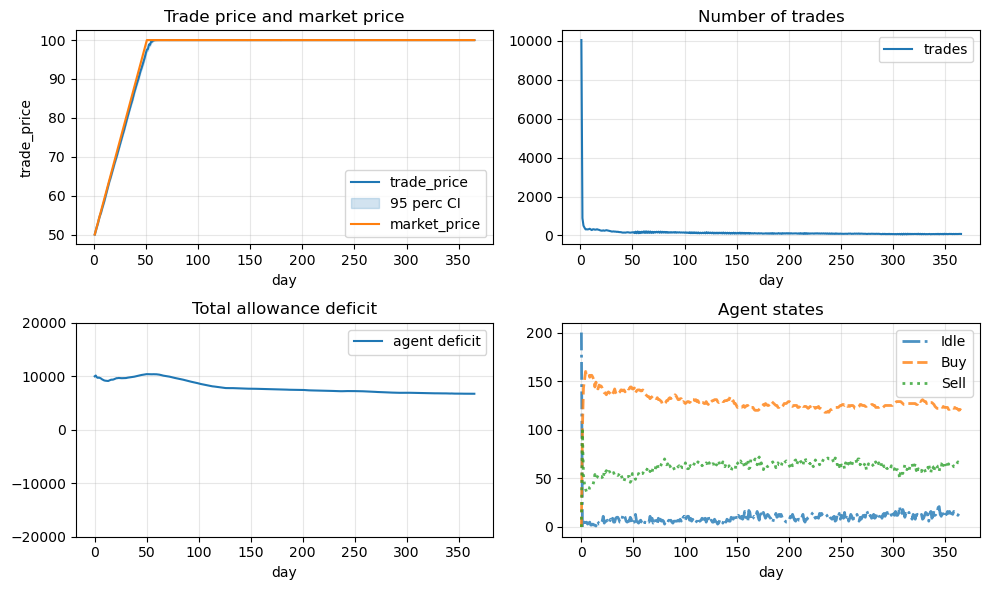

In [268]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

grid = True
grid_alpha = 0.3

# Plot 1: Lineplot for trade_price and market_price
try:
    sns.lineplot(x="day", y="trade_price", data=df, ax=axes[0, 0])
    sns.lineplot(x="day", y="market_price", data=df, ax=axes[0, 0])
except:
    print("No trades were made")
axes[0, 0].legend(["trade_price", "95 perc CI","market_price"])
axes[0, 0].title.set_text("Trade price and market price")
axes[0, 0].grid(grid, alpha=grid_alpha)

# Plot 2: Lineplot for trade_price count
df.groupby("day").trade_price.count().plot(kind="line", ax=axes[0, 1])
axes[0, 1].legend(["trades"])
axes[0, 1].title.set_text("Number of trades")
axes[0, 1].grid(grid, alpha=grid_alpha)

# Plot 3: Lineplot for agent deficit
agent_df.groupby("day").deficit.sum().plot(kind="line", ax=axes[1, 0], alpha=1)
axes[1, 0].legend(["agent deficit"])
axes[1, 0].title.set_text("Total allowance deficit")
#set ylim to 0 to 20000
axes[1, 0].set_ylim([-20000, 20000])
axes[1, 0].grid(grid, alpha=grid_alpha)

# Plot 4: Lineplot for agent count separated by state
state_counts = agent_df.groupby("day").state.value_counts().unstack(fill_value=0)
try:
    state_counts['idle'].plot(kind="line", linestyle='-.',ax=axes[1, 1], alpha = 0.8, lw=2)  # Solid line for 'idle'
except:
    print("No idles were made")
try:
    state_counts['buy'].plot(kind="line", linestyle='--', ax=axes[1, 1], alpha = 0.8, lw=2)  # Dashed line for 'buy'
except:
    print("No buys were made")
try:
    state_counts['sell'].plot(kind="line", linestyle=':', ax=axes[1, 1], alpha = 0.8, lw=2)  # Dotted line for 'sell'
except:
    print("No sells were made")

axes[1, 1].legend(["Idle", "Buy", "Sell"])
axes[1, 1].grid(grid, alpha=grid_alpha)
axes[1, 1].title.set_text("Agent states")


# Adjust layout
plt.tight_layout()
plt.show()

In [269]:
#get number of agents each day
agent_df[agent_df.day==365].value_counts("state")

state
buy     120
sell     64
idle     16
Name: count, dtype: int64

In [270]:
agent_df.groupby(["day", "state"]).state.count()

day  state
0    idle     200
1    buy      101
     sell      99
2    buy      143
     idle       4
             ... 
364  idle      14
     sell      65
365  buy      120
     idle      16
     sell      64
Name: state, Length: 1095, dtype: int64

In [271]:
agent_df.groupby(["day", "state"]).sum()

deficit  count
day state                
0   idle     10000      0
1   buy      20190  10147
    sell    -10043      0
2   buy      10710   9822
    idle         0      0
...            ...    ...
364 idle         0      0
    sell      -122     44
365 buy       6853   6777
    idle         0      0
    sell      -117     41

[1095 rows x 2 columns]

<Axes: xlabel='day'>

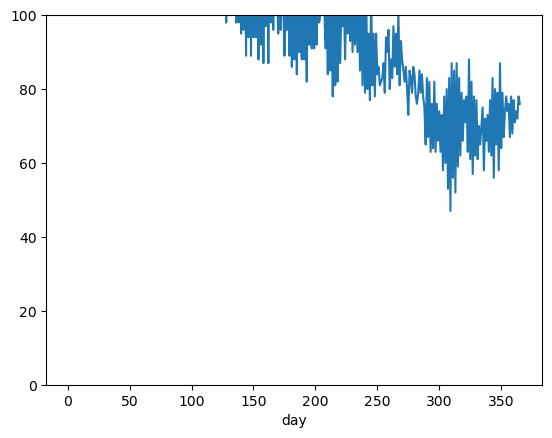

In [272]:
df.groupby("day").trade_price.count().plot(ylim=[0, 100])


In [10]:
import numpy as np
import numpy
q_supplier = np.random.normal(0, 1, 10000)
p_supplier = np.random.normal(0, 1, 10000)
q_demander = np.random.normal(0, 1, 10000)
p_demander = np.random.normal(0, 1, 10000)

In [8]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [14]:
q_supplier = np.array([1, 5, 8, 10])
p_supplier = np.array([0.3, 0.5, 0.7, 0.9])
q_demander = np.array([1, 3, 12, 15])
p_demander = np.array([1.2, 1.0, 0.8, 0.1])

In [ ]:
sns.

In [11]:
q_res = cartesian_product(q_supplier, q_demander)
p_res = cartesian_product(p_supplier, p_demander)

In [13]:
np.argmax((q_res[:,0] >= q_res[:,1]) & (p_res[:,0] > p_res[:,1]))

0